<a href="https://colab.research.google.com/github/P4ttyCakes/SegmentAl/blob/main/DeepV3_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:02<00:00, 72.6MB/s]


Saving Screenshot 2025-02-04 at 9.31.05 AM.png to Screenshot 2025-02-04 at 9.31.05 AM.png


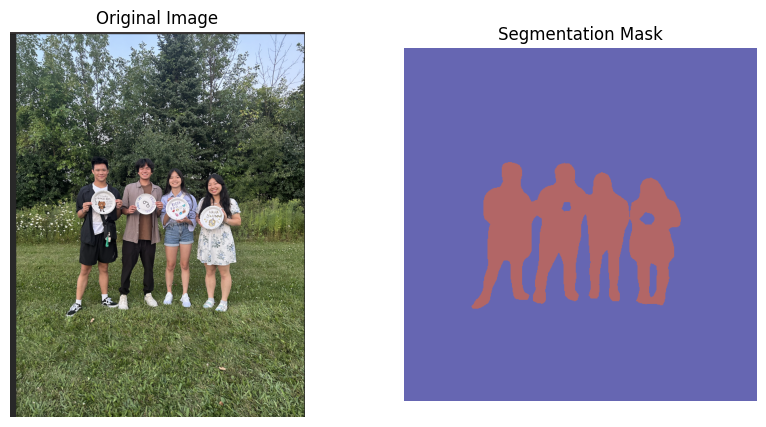

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((520, 520)),  # Resize to model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def visualize_segmentation(image_path, model):
    input_tensor = preprocess_image(image_path)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]

    output_predictions = output.argmax(0).byte().cpu().numpy()

    original_image = Image.open(image_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(output_predictions, cmap='jet', alpha=0.6)
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    plt.show()

model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
model.eval()

# Example usage (replace with actual dataset image path)
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Load the uploaded image
torch.set_grad_enabled(False)
visualize_segmentation(image_path, model)


Saving cat and dog.jpg to cat and dog.jpg


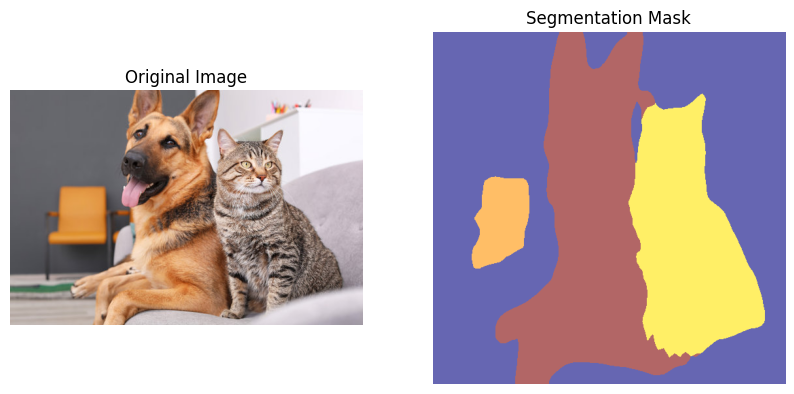

In [2]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Load the uploaded image
torch.set_grad_enabled(False)
visualize_segmentation(image_path, model)